
# Predicting the Price of Used Cars Using Machine Learning Algorithms
<font color = 'Blue'> 
Names: Shin Le, Jeongyeon Kim, Benjamin Horvath, Nico Reategui, Paul Giglio


Proposal: https://docs.google.com/document/d/1zhQrkWmJjjMU6wIfBC78MygGzp-XUrkaUOWALfyAL9Q/edit

Dataset: 
* https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023/data
    
* https://www.kaggle.com/datasets/andreinovikov/used-cars-dataset


<div class="alert alert-block alert-warning">
<b>Update:</b>
We are in stage of cleaning data. We still have a lot of null value. 


* The size is much smaller. we lost a lot of info since I drop a lot of null value.
* Our data now is in years (2009-2024) intead of (1995-2024) after droped ourliers.
* I have to replace some classes in categorical columns to make them make more sense. Biased here, I think 

We still need to do a lot of more work on cleaning our dataset
</div>


<a id="0"></a> <br>
<font color = 'Blue'> 
# Table of Contents

1. [About Dataset](#1)
1. [Importing Libraries](#2)
1. [Functions Implementation](#3)
1. [Loading Data](#4)
1. [Data Preprocessing](#5)
1. [Exploratory Data Analysis (EDA)](#6)
1. [Data Splitting](#7)
1. [Models Evaluations and Predictions](#8)
   1. [*Full Model* with *Linear Regression*](#81)
   1. [Using Sequential Feature Selection for the *Linear Regression*](#82)
   1. [*Decision Tree*](#83)
   1. [*A Pruned Tree*](#84)
   1. [Ensemble Method: *Random Forest Regression*](#85)
   1. [Ensemble Method: *Gradient Boosting Regression*](#86)
   1. [*Support Vector Machine* (SVM)](#87)


<a id="1"></a>
<font color = 'blue'> 
## **1. About Dataset**

This dataset contains data about 762,091 used cars scraped from cars.com. The data was collected on Apr, 2023.

**Feature description**

* manufacturer - name of the car manufacturer
* model - name of the car model
* year - the year when the car was produced
* mileage - the number of miles the car has traveled since production
* engine - car engine
* transmission - type of the car's transmission
* drivetrain - type of the car's drivetrain
* fuel_type - type of fuel that the car consumes
* mpg - the number of miles a car can travel using one gallon of fuel (miles per gallon)
* exterior_color - car exterior color
* interior_color - car interior color
* accidents_or_damage - whether the car was involved in accidents
* one_owner - whether the car was owned by one person
* personal_use_only - whether the car was used only for personal purposes
* seller_name - name of the seller
* seller_rating - seller's rating
* driver_rating - car rating given by drivers
* driver_reviews_num - the number of car reviews left by drivers
* price_drop - price reduction from the initial price
* price - car price

<a id="2"></a>
<font color = 'blue'> 
## **2. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Corrected import
%matplotlib inline  # Ensures that Matplotlib plots are displayed inline

import statsmodels.api as sm


#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder 




UsageError: unrecognized arguments: # Ensures that Matplotlib plots are displayed inline


<a id="3"></a>
<font color = 'blue'> 
## **3. Functions Implementation**


<a id="4"></a>
<font color = 'blue'> 
## **4. Loading Data**

<div class="alert alert-block alert-warning">
<b>Note:</b>

You have to update the link if there is an error when you load data. 

* Open **Github** -> Open the dataset - **germanycars.csv** --> Click "**View Raw**" --> **Copy the link**

You must save before you are able to **Commit & Push** 
* You can go to **File --> Auto Save**
</div>


* This is Germany car dataset that we used on our Proposal

In [2]:
'''
# Define the URL of the CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDUI2ZHP5YRJCPW4ZVKZJ37DUA"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_url)

# Now you have the data in the 'df' DataFrame'''

'\n# Define the URL of the CSV file on GitHub\ncsv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDUI2ZHP5YRJCPW4ZVKZJ37DUA"\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv(csv_url)\n\n# Now you have the data in the \'df\' DataFrame'

* This is new dataset that is not the one we used to write our proposal

In [3]:
import requests
import zipfile
import io
import os
import pandas as pd
from os.path import expanduser

# URL of the ZIP file
url = "https://github.com/syl21b/Car-Price-Prediction/raw/main/cars.csv.zip"

# Directory to save extracted files in your home directory
output_directory = os.path.join(expanduser("~"), "car_data")

# Ensure the output directory exists or create it if not
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Send a GET request to the URL
response = requests.get(url)

if response.status_code == 200:
    # Create a BytesIO object to work with the content
    zip_data = io.BytesIO(response.content)

    # Create a ZipFile object to extract the contents
    with zipfile.ZipFile(zip_data, 'r') as zip_ref:
        # Extract all files from the ZIP archive to the output directory
        zip_ref.extractall(output_directory)

    print("ZIP file has been successfully downloaded and extracted to the specified directory.")
else:
    print(f"Failed to download ZIP file. Status code: {response.status_code}")

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(output_directory, "cars.csv")
df = pd.read_csv(csv_file_path)

# Now you can work with the 'df' DataFrame


Failed to download ZIP file. Status code: 404


<a id="5"></a>
<font color = 'blue'> 
## **5. Data Preprocessing**

In [4]:
# Sample data
df = pd.DataFrame(df)

# Use str.extract to create new columns
df[['Engine Displacement (L)', 'Engine Type', 'Engine Features']] = df['engine'].str.extract(r'(\d+\.\d+)L\s([A-Z0-9]+)\s(.+)$')

# Drop the original 'engine' column if you no longer need it
df = df.drop(columns=['engine'])

# Print the DataFrame
df

,manufacturer,model,year,mileage,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,...,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price,Engine Displacement (L),Engine Type,Engine Features
0,Mazda,CX-90 3.3 Turbo Premium Plus,2024,1.0,8-Speed Automatic,All-wheel Drive,Gasoline,NaN,51K,White,...,1.0,Cox Mazda,3.2,NaN,0,NaN,54920,3.3,I6,Turbo
1,Mazda,CX-90 S Premium Plus,2024,1.0,8-Speed Automatic,All-wheel Drive,Gasoline,NaN,Artisan Red Metallic,White,...,1.0,Cox Mazda,3.2,NaN,0,NaN,61920,NaN,NaN,NaN
2,Acura,Integra A-Spec,2023,6.0,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Red,Ebony,...,0.0,Glenview Luxury Imports,4.9,4.6,5,NaN,37434,1.5,I4,16V GDI DOHC Turbo
3,Acura,Integra A-Spec Technology,2023,9705.0,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Platinum White Pearl,Ebony,...,1.0,Lindsay Acura,3.6,4.6,5,484.0,34516,1.5,I4,16V GDI DOHC Turbo
4,Acura,Integra A-Spec Technology,2023,6.0,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Performance,Orchid,...,1.0,Plaza Auto Mall,4.0,4.6,5,674.0,33221,1.5,I4,16V GDI DOHC Turbo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758030,Toyota,Supra Turbo,1995,15800.0,6-Speed Manual,NaN,Gasoline,17-23,Black,Tan,...,1.0,Motorcar Classics,3.7,4.9,7,10000.0,89900,3.0,I6,24V SPFI DOHC Turbo
758031,Toyota,Supra Turbo,1995,44614.0,6-Speed Manual,Rear-wheel Drive,Gasoline,NaN,Silver,Black,...,1.0,Gold Coast Motors,NaN,4.9,7,6000.0,109900,3.0,I6,Turbo
758032,Volkswagen,Eurovan,1995,91849.0,Manual,Front-wheel Drive,Gasoline,NaN,White,Gray,...,1.0,Pacific Auto Center - Fontana,3.1,4.8,3,1000.0,31995,NaN,NaN,NaN
758033,Volkswagen,Eurovan Campmobile,1995,190336.0,5-Speed Manual,Front-wheel Drive,Gasoline,NaN,White,Gray,...,1.0,Lot 99,1.4,4.8,3,1000.0,25995,5.2,I5,10V SOHC


##### Before handling data
* Show the frequency for each columns. This will initially show us the outliers

In [5]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

Ford             78680
Toyota           59393
Chevrolet        54828
Nissan           48482
Jeep             41543
Mercedes-Benz    40582
Honda            37601
BMW              37509
Kia              35063
GMC              29507
Dodge            25102
Subaru           24762
Volkswagen       24485
Hyundai          22203
Lexus            21292
RAM              19364
Audi             17863
Cadillac         17614
Mazda            15431
Buick            14509
Chrysler         12609
INFINITI         12287
Land Rover       12139
Porsche          11214
Lincoln          10518
Volvo            10022
Acura             8468
Tesla             5883
Mitsubishi        5737
Jaguar            3345
Name: manufacturer, dtype: int64, 

Fusion SE                                3172
Sportage LX                              2873
Corolla LE                               2835
GLC 300 Base 4MATIC                      2718
Sentra SV                                2652
                                         ...

<a id="6"></a>
<font color = 'blue'> 
## **6. Exploratory Data Analysis (EDA)**

## ***Filtering data***


### Handle Missing value

* Price Column - Target

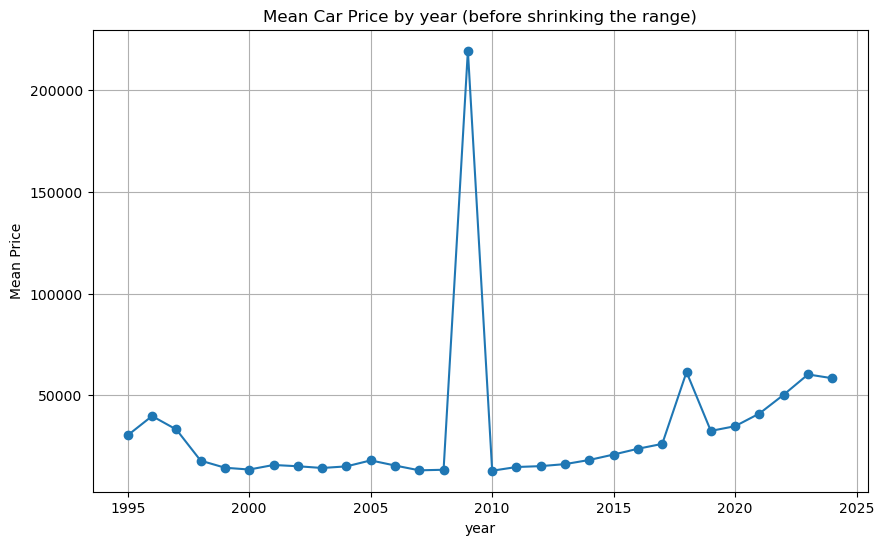

In [6]:
# before shrinkage
mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (before shrinking the range)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()
 

<div class="alert alert-block alert-info">
<b>Problem:</b>
The original dataset has the abnormal mean price in year 2009. So, we shrink the Price in the range (0,200000). This could a way to handle outliers. 
</div>



In [7]:
df=df[df['price'].between(0,200000)]

In [8]:

# Group by the 'year' column and calculate the mean price for each year
yearly_mean_prices = df.groupby('year')['price'].mean()

# Fill NaN values in the 'price' column with the mean price of their respective year
df['price'].fillna(df['year'].map(yearly_mean_prices), inplace=True)

df.shape

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_19892/1379729934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'].fillna(df['year'].map(yearly_mean_prices), inplace=True)


(756724, 22)

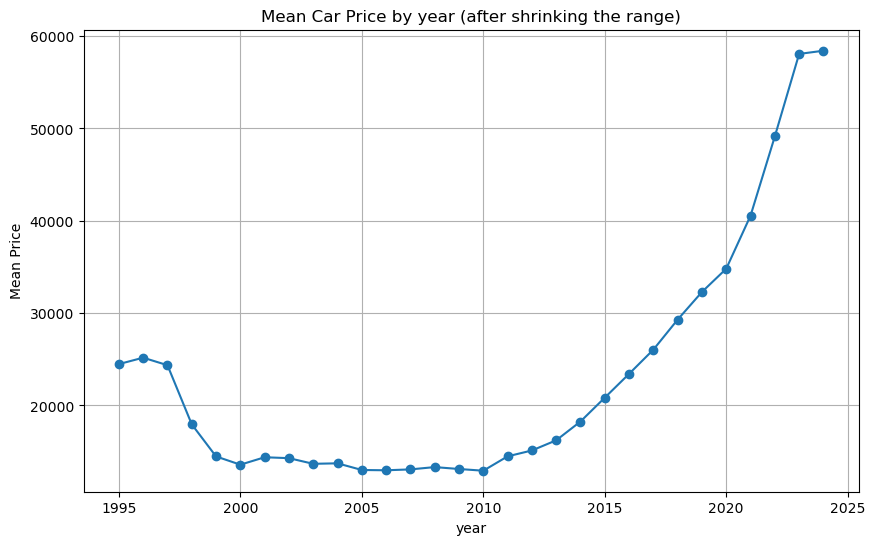

In [9]:


mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (after shrinking the range)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

#### Mapping from long form to abbreviation
* Drivetrain

In [10]:

df = pd.DataFrame(df)

# Create a mapping from long form to abbreviation
drivetrain_mapping = {
    'All-wheel Drive': 'AWD',
    'Front-wheel Drive': 'FWD',
    'Four-wheel Drive': '4WD',
    'Rear-wheel Drive': 'RWD'
}

# Use the replace method to update the drivetrain column
df['drivetrain'] = df['drivetrain'].replace(drivetrain_mapping)


* fuel_type

In [11]:
df = pd.DataFrame(df)
# Create a dictionary for mapping
drivetrain_mapping = {
    'Gasoline Fuel': 'Gasoline',
    'Gas': 'Gasoline',
    'Plug-In Hybrid': 'Hybrid',
    'Hybrid Fuel': 'Hybrid',
    'Gas/Electric Hybrid': 'Hybrid',
    'Gasoline/Mild Electric Hybrid': 'Hybrid',
    'Diesel Fuel': 'Diesel',
    'Rear-wheel Drive': 'Electric',
    'E85 Flex Fuel': 'Flex Fuel',
    'Flex Fuel Capability': 'Flex Fuel'
}

# Use the replace method to update the drivetrain column
df['fuel_type'] = df['fuel_type'].replace(drivetrain_mapping)


#### Splitting `MPG` column into two separate columns

In [12]:
df['mpg'].fillna('0-0', inplace=True)



In [13]:
# Split the "MPG Range" into two columns
#df[['City MPG', 'Highway MPG']] = df['mpg'].str.split('-', expand=True).astype(int)
df[['City MPG', 'Highway MPG']] = df['mpg'].str.split('-', expand=True)

In [14]:
# Custom function to convert elements to int or replace with zero
def convert_to_int_or_zero(value):
    if isinstance(value, str):
        # Remove non-numeric characters and try to convert to int
        numeric_value = ''.join(filter(str.isdigit, value))
        if numeric_value:
            return int(numeric_value)
    return 0

# Apply the custom function to 'City MPG' and 'Highway MPG' columns
df['City MPG'] = df['City MPG'].apply(convert_to_int_or_zero)
df['Highway MPG'] = df['Highway MPG'].apply(convert_to_int_or_zero)


In [15]:
# Replace "N/A" values with NaN
df['City MPG'] .replace(0, np.nan, inplace=True)
df['Highway MPG'].replace(0, np.nan, inplace=True)

In [16]:
df= df.drop('mpg', axis=1)

In [17]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating              210877
driver_rating               29309
driver_reviews_num              0
price_drop                 348758
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                   145894
Highway MPG                153944
dtype: int64

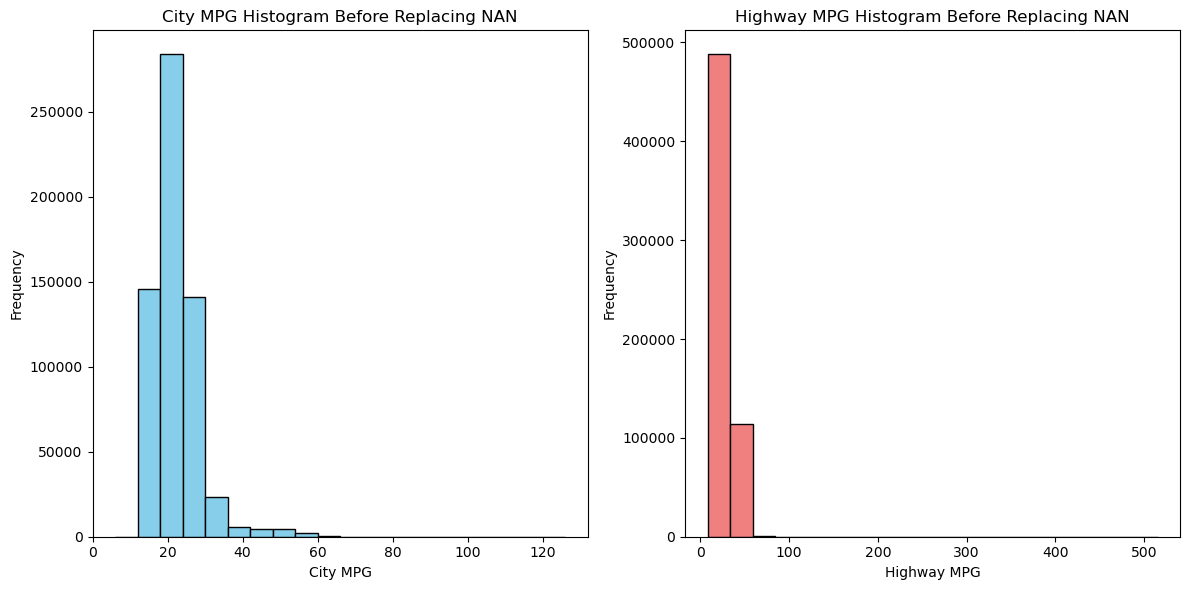

In [18]:
def Create_MPG_histograms(df, str):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['City MPG'], bins=20, color='skyblue', edgecolor='black')
    plt.title('City MPG Histogram '+str+' Replacing NAN')
    plt.xlabel('City MPG')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(df['Highway MPG'], bins=20, color='lightcoral', edgecolor='black')
    plt.title('Highway MPG Histogram '+str+' Replacing NAN')
    plt.xlabel('Highway MPG')
    plt.ylabel('Frequency')

    plt.tight_layout()

    # Show the histograms
    plt.show()
    
Create_MPG_histograms(df, 'Before')

* **Replace `NAN` in '`City MPG`' and '`Highway MPG`' by the `Mean` of each column**

In [19]:
df['City MPG'] .replace(np.nan,df['City MPG'].mean(), inplace=True)
df['Highway MPG'].replace(np.nan,df['Highway MPG'].mean(), inplace=True)

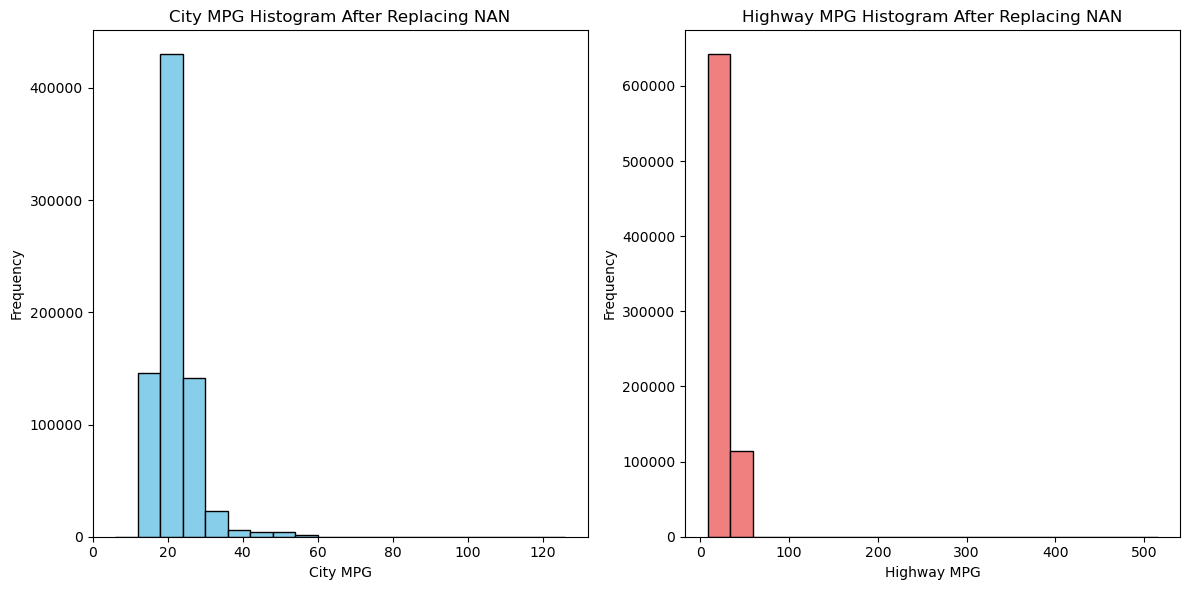

In [20]:
Create_MPG_histograms(df, 'After')

In [21]:
df= df.drop('price_drop', axis=1)       #Drop this column since it does not provide useful information and has a lot of null values.
df

,manufacturer,model,year,mileage,transmission,drivetrain,fuel_type,exterior_color,interior_color,accidents_or_damage,...,seller_name,seller_rating,driver_rating,driver_reviews_num,price,Engine Displacement (L),Engine Type,Engine Features,City MPG,Highway MPG
0,Mazda,CX-90 3.3 Turbo Premium Plus,2024,1.0,8-Speed Automatic,AWD,Gasoline,51K,White,0.0,...,Cox Mazda,3.2,NaN,0,54920,3.3,I6,Turbo,21.622774,28.657079
1,Mazda,CX-90 S Premium Plus,2024,1.0,8-Speed Automatic,AWD,Gasoline,Artisan Red Metallic,White,0.0,...,Cox Mazda,3.2,NaN,0,61920,NaN,NaN,NaN,21.622774,28.657079
2,Acura,Integra A-Spec,2023,6.0,Automatic CVT,FWD,Gasoline,Red,Ebony,0.0,...,Glenview Luxury Imports,4.9,4.6,5,37434,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
3,Acura,Integra A-Spec Technology,2023,9705.0,Automatic CVT,FWD,Gasoline,Platinum White Pearl,Ebony,0.0,...,Lindsay Acura,3.6,4.6,5,34516,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
4,Acura,Integra A-Spec Technology,2023,6.0,Automatic CVT,FWD,Gasoline,Performance,Orchid,0.0,...,Plaza Auto Mall,4.0,4.6,5,33221,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758030,Toyota,Supra Turbo,1995,15800.0,6-Speed Manual,NaN,Gasoline,Black,Tan,0.0,...,Motorcar Classics,3.7,4.9,7,89900,3.0,I6,24V SPFI DOHC Turbo,17.000000,23.000000
758031,Toyota,Supra Turbo,1995,44614.0,6-Speed Manual,RWD,Gasoline,Silver,Black,0.0,...,Gold Coast Motors,NaN,4.9,7,109900,3.0,I6,Turbo,21.622774,28.657079
758032,Volkswagen,Eurovan,1995,91849.0,Manual,FWD,Gasoline,White,Gray,0.0,...,Pacific Auto Center - Fontana,3.1,4.8,3,31995,NaN,NaN,NaN,21.622774,28.657079
758033,Volkswagen,Eurovan Campmobile,1995,190336.0,5-Speed Manual,FWD,Gasoline,White,Gray,0.0,...,Lot 99,1.4,4.8,3,25995,5.2,I5,10V SOHC,21.622774,28.657079


* #### **Handling `NAN` in `seller_rating`**

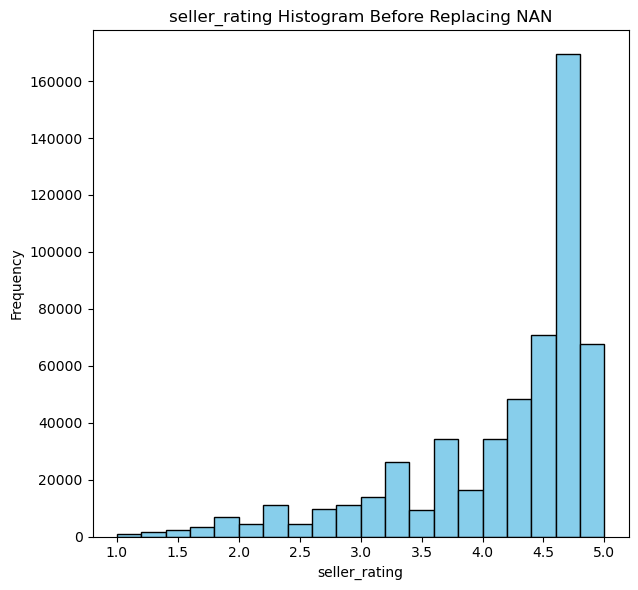

In [22]:

def Create_seller_rating_histograms(df, str):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['seller_rating'], bins=20, color='skyblue', edgecolor='black')
    plt.title('seller_rating Histogram '+str+' Replacing NAN')
    plt.xlabel('seller_rating')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Show the histograms
    plt.show()
    
Create_seller_rating_histograms(df, 'Before')

In [23]:
df['seller_rating'].replace(np.nan,df['seller_rating'].mean(), inplace=True)

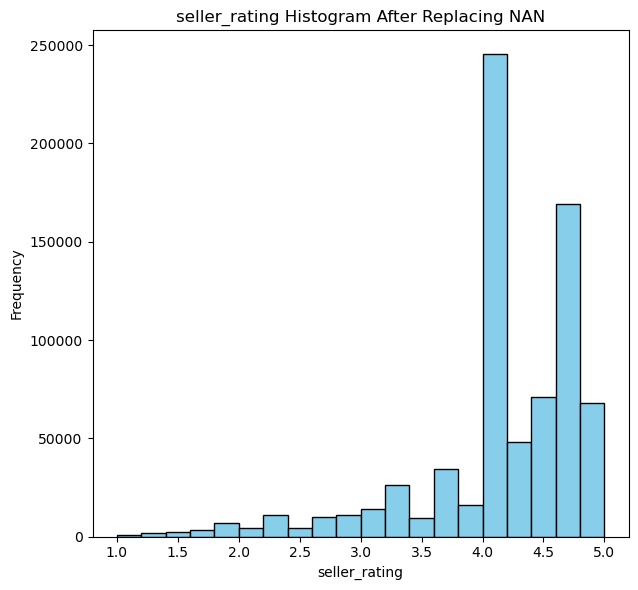

In [24]:
Create_seller_rating_histograms(df, 'After')

In [25]:
df.dropna()

,manufacturer,model,year,mileage,transmission,drivetrain,fuel_type,exterior_color,interior_color,accidents_or_damage,...,seller_name,seller_rating,driver_rating,driver_reviews_num,price,Engine Displacement (L),Engine Type,Engine Features,City MPG,Highway MPG
2,Acura,Integra A-Spec,2023,6.0,Automatic CVT,FWD,Gasoline,Red,Ebony,0.0,...,Glenview Luxury Imports,4.900000,4.6,5,37434,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
3,Acura,Integra A-Spec Technology,2023,9705.0,Automatic CVT,FWD,Gasoline,Platinum White Pearl,Ebony,0.0,...,Lindsay Acura,3.600000,4.6,5,34516,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
6,Acura,Integra A-Spec Technology,2023,10805.0,6-Speed Manual,FWD,Gasoline,Gray,Ebony,0.0,...,Honda of Keene,4.500000,4.6,5,37500,1.5,I4,16V GDI DOHC Turbo,26.000000,36.000000
7,Acura,Integra A-Spec,2023,6612.0,Automatic CVT,FWD,Gasoline,Apex Blue Pearl,Ebony,0.0,...,Audi Fort Myers,4.600000,4.6,5,32995,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
8,Acura,Integra A-Spec Technology,2023,3305.0,Automatic CVT,FWD,Gasoline,Performance Red Pearl,Orchid,0.0,...,Acura of Concord,4.159732,4.6,5,34019,1.5,I4,16V GDI DOHC Turbo,29.000000,36.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758016,Toyota,Camry LE,1995,126451.0,4-Speed Automatic,RWD,Gasoline,Tan,Tan,0.0,...,Uzdcarz Inc.,4.159732,4.5,32,3488,3.0,V6,24V SPFI DOHC,20.000000,28.000000
758017,Toyota,4Runner SR5 V6,1995,200331.0,5-Speed Manual,4WD,Gasoline,Dark Gray Metallic,Gray,0.0,...,Columbia Motors,2.900000,4.2,8,9991,3.0,V6,SPFI SOHC,13.000000,16.000000
758020,Toyota,Corolla DX,1995,168722.0,5-Speed Manual,FWD,Gasoline,Wintergreen Metallic,Gray,1.0,...,Performance Toyota Bountiful,4.200000,4.3,18,5000,1.8,I4,16V SPFI SOHC,28.000000,34.000000
758028,Toyota,Land Cruiser,1995,237603.0,4-Speed Automatic,4WD,Gasoline,Green,Tan,1.0,...,Dynamic Motorsports Of Texas,4.159732,4.6,6,16995,4.5,I6,24V SPFI DOHC,13.000000,16.000000


In [26]:
df.isnull().sum() # Checking null values on each column

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating                   0
driver_rating               29309
driver_reviews_num              0
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                        0
Highway MPG                     0
dtype: int64

In [27]:
# Load your dataset (replace 'your_data.csv' with your actual file)

# Use value_counts to count the frequency of each Engine Type
engine_type_counts = df['Engine Features'].value_counts()

# Get the top 20 values with the highest frequency
top_20_engine_types = engine_type_counts.head(40)

# Print the top 20 values and their frequencies
print(top_20_engine_types)

16V GDI DOHC Turbo                  121200
24V MPFI DOHC                        71454
16V MPFI DOHC                        58584
16V GDI DOHC                         56198
24V GDI DOHC                         43984
16V GDI OHV                          21721
24V GDI DOHC Twin Turbo              18418
16V MPFI OHV                         18140
16V MPFI SOHC                        17515
24V GDI DOHC Turbo                   15633
24V PDI DOHC                         15596
16V MPFI DOHC Hybrid                 12292
32V DDI OHV Turbo Diesel             11828
16V PDI DOHC                         11134
32V MPFI DOHC                         9823
32V GDI DOHC Twin Turbo               9516
24V GDI SOHC                          9065
16V MPFI DOHC Turbo                   8086
32V GDI DOHC                          6591
16V PDI DOHC Turbo                    6468
24V PDI DOHC Twin Turbo               6163
16V PDI DOHC Hybrid                   6024
24V MPFI SOHC                         5982
Cylinder En

In [28]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating                   0
driver_rating               29309
driver_reviews_num              0
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                        0
Highway MPG                     0
dtype: int64

We still have a lot of null value

In [29]:
df.shape

(756724, 22)

#### after filtering data

In [30]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

Ford             78646
Toyota           59390
Chevrolet        54813
Nissan           48472
Jeep             41542
Mercedes-Benz    40094
Honda            37601
BMW              37491
Kia              35063
GMC              29501
Dodge            25091
Subaru           24761
Volkswagen       24485
Hyundai          22202
Lexus            21292
RAM              19362
Audi             17847
Cadillac         17585
Mazda            15431
Buick            14509
Chrysler         12609
INFINITI         12287
Land Rover       12060
Porsche          10629
Lincoln          10517
Volvo            10022
Acura             8458
Tesla             5883
Mitsubishi        5737
Jaguar            3344
Name: manufacturer, dtype: int64, 

Fusion SE                                    3172
Sportage LX                                  2873
Corolla LE                                   2835
GLC 300 Base 4MATIC                          2718
Sentra SV                                    2652
                        

In [31]:
df.info() #shows a summary of our dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756724 entries, 0 to 758034
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   manufacturer             756724 non-null  object 
 1   model                    756724 non-null  object 
 2   year                     756724 non-null  int64  
 3   mileage                  756246 non-null  float64
 4   transmission             747166 non-null  object 
 5   drivetrain               737314 non-null  object 
 6   fuel_type                735621 non-null  object 
 7   exterior_color           748044 non-null  object 
 8   interior_color           700471 non-null  object 
 9   accidents_or_damage      732698 non-null  float64
 10  one_owner                727494 non-null  float64
 11  personal_use_only        732594 non-null  float64
 12  seller_name              748229 non-null  object 
 13  seller_rating            756724 non-null  float64
 14  driv

* Check and drop **Null** values

In [32]:
df.isnull().sum()

manufacturer                    0
model                           0
year                            0
mileage                       478
transmission                 9558
drivetrain                  19410
fuel_type                   21103
exterior_color               8680
interior_color              56253
accidents_or_damage         24026
one_owner                   29230
personal_use_only           24130
seller_name                  8495
seller_rating                   0
driver_rating               29309
driver_reviews_num              0
price                           0
Engine Displacement (L)    116191
Engine Type                116191
Engine Features            116191
City MPG                        0
Highway MPG                     0
dtype: int64

There is null value in **fuel_consumption_g_km** column. So, we need to drop these before using it

In [33]:
#df=df.dropna().reset_index(drop=True)

* Check and drop duplicates:

In [34]:
df=df.drop_duplicates()

The data set after cleaning up

In [35]:
df.shape

(747466, 22)

* Counting the data for each feature:

In [36]:
'''for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")'''

'for feature in df.columns.tolist():\n    print(f"{df[feature].value_counts()}, \n")'

We can observe the presence of outliers, and the data spans a wide range.

## **Dectecting outliers**
* ### **For numerical columns**

Getting numerical columns

In [37]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_cols.remove('Senior Citizen')
num_columns=df[numerical_cols]

* Mean Car Price by year with outliers

<div class="alert alert-block alert-warning">
<b>Note:</b>  This method is just applied for <b>numerical features</b>. <br>
There is no specific way to detect outlier for <b>categorical columns</b>. We can plot the Frequency vs Price for each categorical columns, and then decide the outliers depend on the frequency.
</div>


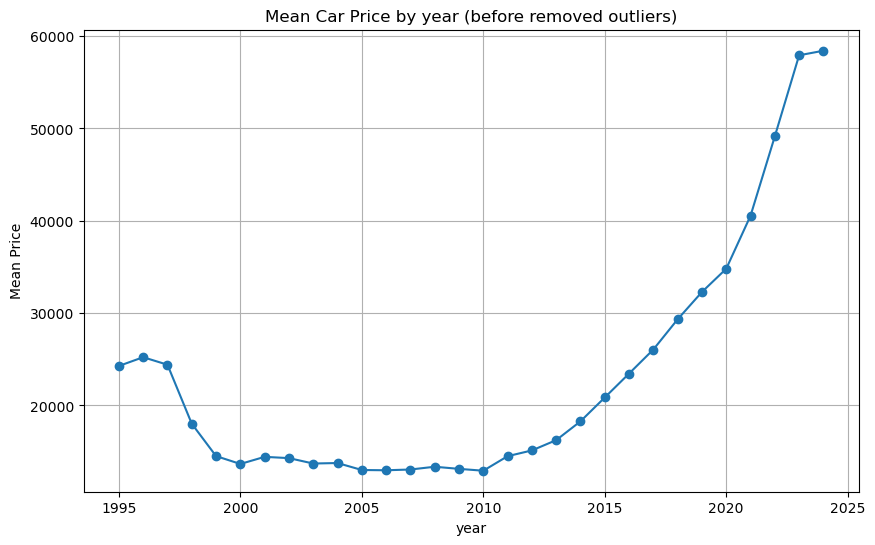

In [38]:

mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (before removed outliers)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

We can see that in 2009, the price was so arnormal 

In [39]:
Q1 = num_columns[numerical_cols].quantile(0.25)
Q3 = num_columns[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and create a boolean mask
outliers_mask = (num_columns[numerical_cols] < lower_bound) | (num_columns[numerical_cols] > upper_bound)

# Drop the rows containing outliers
num_columns = num_columns[~outliers_mask]

In [40]:
numerical_cols

['year',
 'mileage',
 'accidents_or_damage',
 'one_owner',
 'personal_use_only',
 'seller_rating',
 'driver_rating',
 'driver_reviews_num',
 'price',
 'City MPG',
 'Highway MPG']

In [41]:
num_columns.shape

(747466, 11)

This is new numerical columns after removed the outliers

In [42]:
new_num_columns= num_columns.dropna() #drop the rows which are contain NAN 
new_num_columns.shape

(374603, 11)

* Plot Average Price vs Years ((after removed outliers))


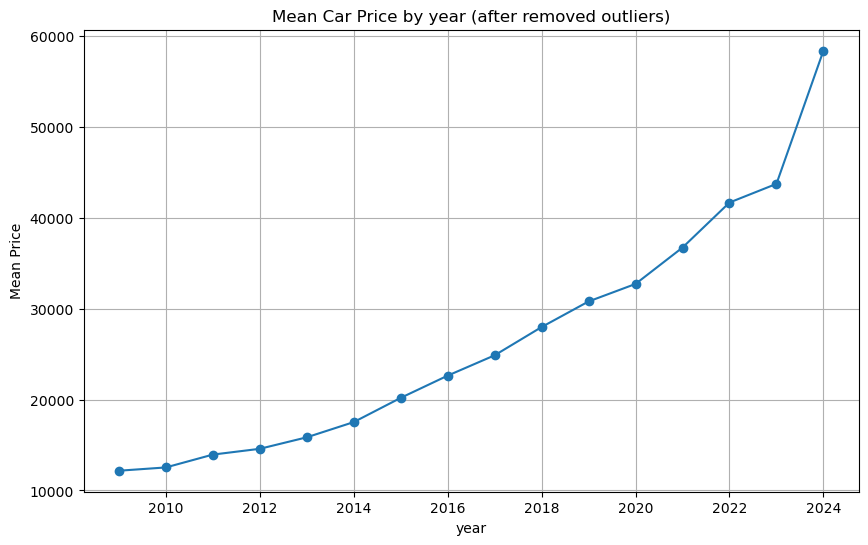

In [43]:

mean_prices_by_year = num_columns.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (after removed outliers)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_19892/3780897045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_num_columns['mileage'] = pd.to_numeric(new_num_columns['mileage'], errors='coerce')
/var/folders/3b/8cnrvmc53q97m9nqbnvfytlm0000gn/T/ipykernel_19892/3780897045.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_num_columns['mileage_ranges'] = pd.cut(new_num_columns['mileage'], bins=num_bins, labels=labels, include_lowest=True)


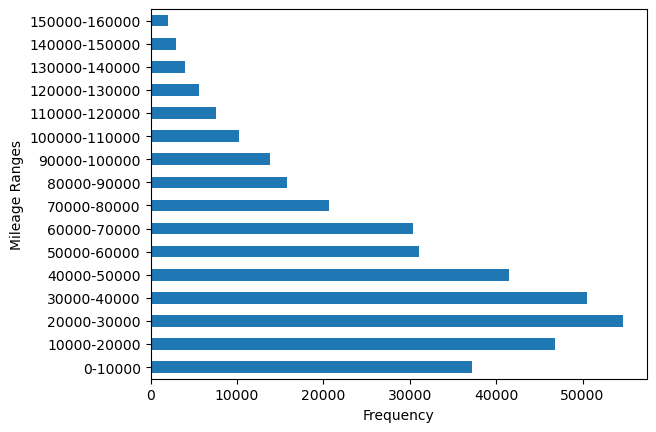

In [44]:
# Convert 'mileage_in_km' column to numeric if it's not already
new_num_columns['mileage'] = pd.to_numeric(new_num_columns['mileage'], errors='coerce')

# Define the number of bins and calculate the range based on the data
num_bins = 16
min_range = 0
max_range = new_num_columns['mileage'].max()

# Create labels with custom ranges
bin_size = round((max_range - min_range) / num_bins,-3)
labels = [f'{int(min_range + i * bin_size)}-{int(min_range + (i + 1) * bin_size)}' for i in range(num_bins)]

# Using pd.cut, divide the 'mileage_in_km' column into bins with labels
new_num_columns['mileage_ranges'] = pd.cut(new_num_columns['mileage'], bins=num_bins, labels=labels, include_lowest=True)


# Create the bar plot
fig, ax = plt.subplots()
value_counts = new_num_columns['mileage_ranges'].value_counts()
value_counts[labels].plot(ax=ax, kind='barh', ylabel='Mileage Ranges', xlabel='Frequency')
plt.show()

* ### **For categorical columns:**
We need to plot them vs Price to see the pattern

In [45]:
cat_columns= df.select_dtypes(include=['object']).columns.tolist()
 #these are the columns that wee need to plot se dectect the outliers

TypeError: can only concatenate str (not "type") to str

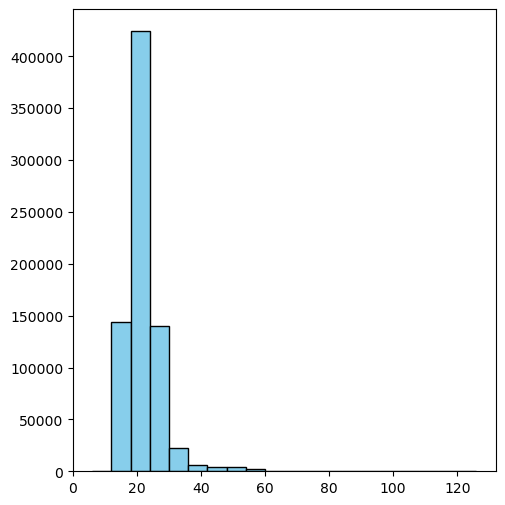

In [46]:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df['City MPG'], bins=20, color='skyblue', edgecolor='black')
    plt.title('City MPG Histogram '+str+' Replacing NAN')
    plt.xlabel('City MPG')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(df['Highway MPG'], bins=20, color='lightcoral', edgecolor='black')
    plt.title('Highway MPG Histogram '+str+' Replacing NAN')
    plt.xlabel('Highway MPG')
    plt.ylabel('Frequency')

    plt.tight_layout()

    # Show the histograms
    plt.show()

In [ ]:

# Create a figure with multiple subplots
fig = plt.figure(figsize=(8, 6 * len(cat_columns)))
for i, cat_feature in enumerate(cat_columns):
    plt.subplot(1, 2, i)
    ax = fig.add_subplot(len(cat_columns), 1, i + 1)
    df[cat_feature].value_counts().plot(ax=ax, kind='bar', xlabel=cat_feature, ylabel='Frequency')
    ax.set_title(cat_feature)

plt.tight_layout()
plt.show()


In [ ]:
'''# Calculate the number of rows needed to accommodate all categorical features
num_rows = len(cat_columns)
num_cols = 2  # Two subplots per row

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Flatten the axs array to access each subplot
axs = axs.flatten()

for i, cat_feature in enumerate(cat_columns):
    ax = axs[i]
    df[cat_feature].value_counts().plot(ax=ax, kind='bar')
    ax.set_xlabel(cat_feature)
    ax.set_ylabel('Frequency')
    ax.set_title(cat_feature)

# Hide any extra empty subplots
for i in range(len(cat_columns), num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()'''

<div class="alert alert-block alert-warning">
<b>Discussion:</b>  `Based on these plots for categorical features, we can decide how much data we can remove`
</div>

Let's drop these classes from categorical columns:<br>

* `Unknow`, `Semi-automatic` from `transmission_type` column<br>
* `LPG`, `CNG`, `Diesel Hybrid`, `Hydrogen`, `Electric`, `Ethanol` from `fuel_type` columns

### **!!! We can drop more classes if needed**

In [ ]:
df = df.loc[~df['fuel_type'].isin(['LPG', 'CNG', 'Diesel Hybrid', 'Hydrogen', 'Electric', 'Ethanol'])]
df = df.loc[~df['transmission_type'].isin(['Unknown', 'Semi-automatic'])]
#reset the index
df.reset_index(drop=True)

In [ ]:
'''data= pd.concat([new_num_columns , cat_columns, Y], axis=1)
data = data.dropna().reset_index(drop=True)
data.info()'''